In [1]:
%env OMP_NUM_THREADS=1

import numpy as np
import timeit

env: OMP_NUM_THREADS=1


# Метод сопряжённых градиентов 

In [2]:
def matvec(A, b):
    n = b.size
    z = np.zeros(n)
    for i in range(n):
        for j in range(n):
            z[i] += A[i][j] * b[j]
    return z

In [3]:
def SG(A, b, x_0, eps, matvec, verbose = True):
    x = x_0.copy()
    n = x.size
    r = b - matvec(A, x) # b - A @ x
    r0 = np.linalg.norm(r)
    p = r
    tmp = np.zeros(n)
    for i in range(1, n + 1):
        if (i % 15 == 0):
            r = b - matvec(A, x) # b - A @ x
        alpha = np.inner(r, r)
        beta = 1 / alpha
        tmp = matvec(A, p) #A @ p
        alpha /= np.inner(tmp, p)
        r -= alpha * tmp
        x += alpha * p
        if verbose:
            print(f"падение невязки на {i}) шаге: ", np.linalg.norm(r) / r0)
        if (np.linalg.norm(r) / r0 < eps):
            if verbose:
                print(f"EPS {np.linalg.norm(r) / r0}")
                print(f"{i} iterations")
            return
        beta *= np.inner(r, r)
        p = beta * p + r
    if verbose:
        print(f"EPS {np.linalg.norm(r) / r0}")
        print("Full iterations")

In [10]:
n = 2000
eps = 1e-8
A = np.random.rand(n, n)
A = (A + A.T) / 2
for i in range(n):
    A[i, i] = A[i, :].sum()
x_sol = np.random.rand(n)
b = A @ x_sol
x_0 = np.random.rand(n)

In [11]:
%%time
SG(A, b, x_0, eps, matvec)

падение невязки на 1) шаге:  0.01955945948979688
падение невязки на 2) шаге:  0.006193518797085412
падение невязки на 3) шаге:  0.000126045056803046
падение невязки на 4) шаге:  3.603528848037276e-06
падение невязки на 5) шаге:  8.134553433940533e-07
падение невязки на 6) шаге:  1.712428432522514e-08
падение невязки на 7) шаге:  7.570144986247755e-10
EPS 7.570144986247755e-10
7 iterations
CPU times: user 21.8 s, sys: 312 µs, total: 21.8 s
Wall time: 21.8 s


# просто Numba

In [14]:
import numba

In [15]:
@numba.jit(nopython=True)
def matvec(A, b):
    n = b.size
    z = np.zeros(n)
    for i in range(n):
        for j in range(n):
            z[i] += A[i][j] * b[j]
    return z

In [16]:
%%time
SG(A, b, x_0, eps, matvec)

падение невязки на 1) шаге:  0.01955945948979688
падение невязки на 2) шаге:  0.006193518797085412
падение невязки на 3) шаге:  0.000126045056803046
падение невязки на 4) шаге:  3.603528848037276e-06
падение невязки на 5) шаге:  8.134553433940533e-07
падение невязки на 6) шаге:  1.712428432522514e-08
падение невязки на 7) шаге:  7.570144986247755e-10
EPS 7.570144986247755e-10
7 iterations
CPU times: user 776 ms, sys: 40 ms, total: 816 ms
Wall time: 943 ms


# Параллельная Numba

In [269]:
from numba import prange

In [275]:
@numba.jit(nopython=True, parallel=True)
def matvec(A, b):
    n = b.size
    z = np.zeros(n)
    for i in prange(n):
        for j in range(n):
            z[i] += A[i][j] * b[j]
    return z

In [276]:
numba.set_num_threads(1)

In [278]:
%%time
SG(A, b, x_0, eps, matvec)

падение невязки на 1) шаге:  0.040691059694569987
падение невязки на 2) шаге:  0.008988069018311973
падение невязки на 3) шаге:  0.0002421522667315467
падение невязки на 4) шаге:  4.619481236168102e-05
падение невязки на 5) шаге:  1.7252224017405605e-06
падение невязки на 6) шаге:  7.955199227529846e-08
падение невязки на 7) шаге:  2.1929894216912e-08
падение невязки на 8) шаге:  4.644132824462652e-10
EPS 4.644132824462652e-10
8 iterations
CPU times: user 11.7 ms, sys: 3.96 ms, total: 15.7 ms
Wall time: 13.4 ms


# Анализ результатов

In [279]:
times = []

In [280]:
eps = 1e-8
for size in np.linspace(1e3, 2 * 1e4, 20):
    n = int(size)
    A = np.random.rand(n, n)
    A = (A + A.T) / 2
    for i in range(n):
        A[i, i] = A[i, :].sum()
    x_sol = np.random.rand(n)
    b = A @ x_sol
    x_0 = np.random.rand(n)
    
    for j in range(1, 11):
        numba.set_num_threads(j)
        print(f"Size:{size}, Threads: {j}")
        details = %timeit -o -r 10 -q SG(A, b, x_0, eps, matvec, verbose=False)
        times.append(details.average)

Size:1000.0, Threads: 1
Size:1000.0, Threads: 2
Size:1000.0, Threads: 3
Size:1000.0, Threads: 4
Size:1000.0, Threads: 5
Size:1000.0, Threads: 6
Size:1000.0, Threads: 7
Size:1000.0, Threads: 8
Size:1000.0, Threads: 9
Size:1000.0, Threads: 10
Size:2000.0, Threads: 1
Size:2000.0, Threads: 2
Size:2000.0, Threads: 3
Size:2000.0, Threads: 4
Size:2000.0, Threads: 5
Size:2000.0, Threads: 6
Size:2000.0, Threads: 7
Size:2000.0, Threads: 8
Size:2000.0, Threads: 9
Size:2000.0, Threads: 10
Size:3000.0, Threads: 1
Size:3000.0, Threads: 2
Size:3000.0, Threads: 3
Size:3000.0, Threads: 4
Size:3000.0, Threads: 5
Size:3000.0, Threads: 6
Size:3000.0, Threads: 7
Size:3000.0, Threads: 8
Size:3000.0, Threads: 9
Size:3000.0, Threads: 10
Size:4000.0, Threads: 1
Size:4000.0, Threads: 2
Size:4000.0, Threads: 3
Size:4000.0, Threads: 4
Size:4000.0, Threads: 5
Size:4000.0, Threads: 6
Size:4000.0, Threads: 7
Size:4000.0, Threads: 8
Size:4000.0, Threads: 9
Size:4000.0, Threads: 10
Size:5000.0, Threads: 1
Size:5000.0,

In [301]:
times = np.array(times).reshape(20, 10)

In [292]:
size, threads = np.meshgrid(np.arange(1, 11), np.linspace(1e3, 2 * 1e4, 20))

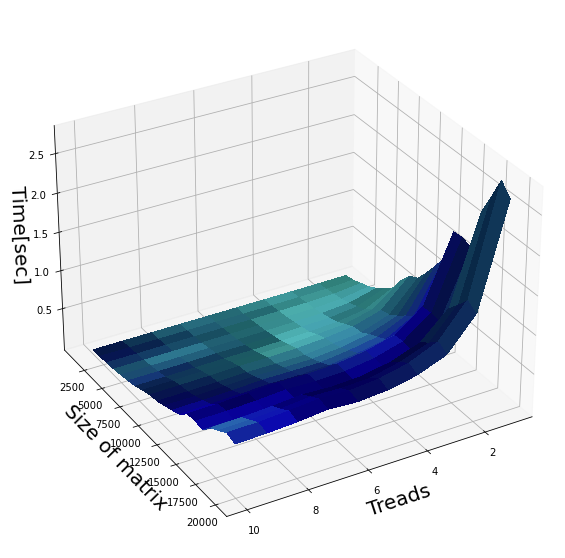

In [347]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))
ax.view_init(30, 60)
ax.set_xlabel("Treads", fontsize = 20)
ax.set_ylabel("Size of matrix", fontsize = 20)
ax.set_zlabel("Time[sec]", fontsize = 20)

ls = LightSource(270, 45)
rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(size, threads, times, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [24]:
import plotly.graph_objects as go

In [349]:
fig = go.Figure(data=[go.Surface(z=times, x=size, y=threads)])
fig.update_layout(title='Time consuming', autosize=False,
                  width=750, height=750,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene= go.Scene(
                    xaxis=go.XAxis(title='threads'),
                    yaxis=go.YAxis(title='size of matrix'),
                    zaxis=go.ZAxis(title='Time[sec]')))
fig.show()

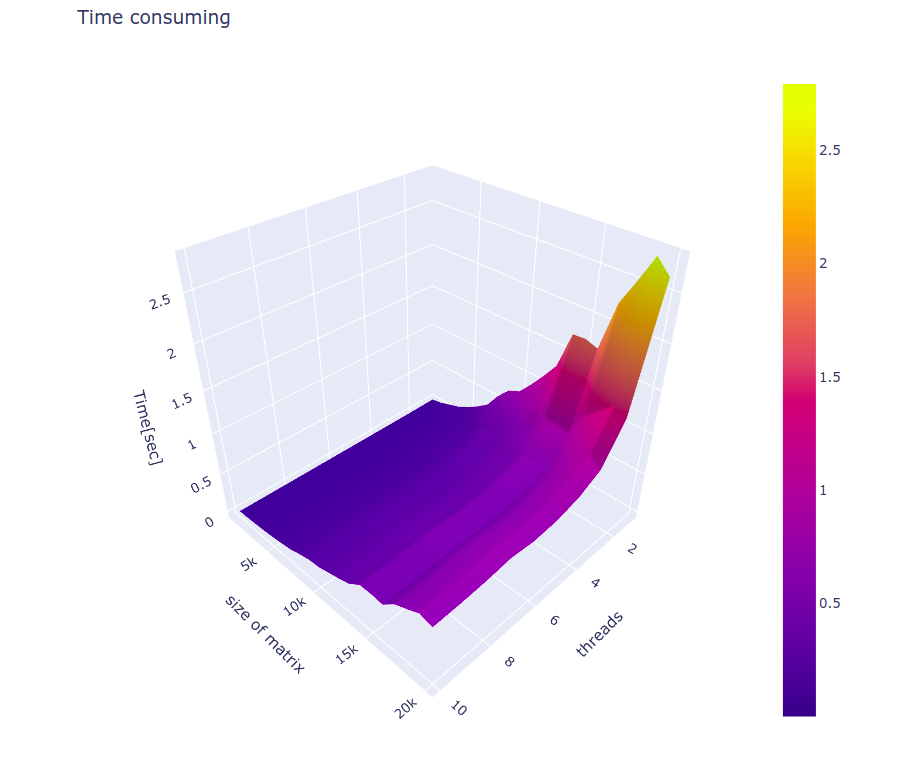

# Multi Processing

In [1]:
import numpy as np
from multiprocessing import Process, Manager, Array, Pool, Pipe, cpu_count, Barrier, Queue
import ctypes
import time
import os
import gc
from itertools import repeat
%env OMP_NUM_THREADS=1

env: OMP_NUM_THREADS=1


In [2]:
def simple_matvec(A, z_vec_shared, r_vec_shared, n,  i1, i2, task_queue, feedback_queue, stop): # A * r_vec = z_vec
    z_vec = np.frombuffer(z_vec_shared, dtype=np.float64)
    r_vec = np.frombuffer(r_vec_shared, dtype=np.float64)
    while True:
        task = task_queue.get() # ожидание задания
        if (task == 2):
            break
        z_vec[i1:i2] = 0
        for i in range(i1, i2):
            for j in range(n):
                z_vec[i] += A[i][j] * r_vec[j]
        feedback_queue.put(1)
        stop.wait() # ждём другие процессы

def SG(A, b, x_0, eps, num_proc, verbose = True):
    n = b.size
    block_size = n // num_proc
    i_pos = [i * block_size for i in range(num_proc + 1)]
    i_pos[-1] += n % num_proc
    flag = 1 # 1 - work; 2 - end

    # общая память
    z_vec_shared = Array(ctypes.c_double, n, lock=False)
    r_vec_shared = Array(ctypes.c_double, n, lock=False)
    z_vec = np.frombuffer(z_vec_shared, dtype=np.float64)
    r_vec = np.frombuffer(r_vec_shared, dtype=np.float64)

    # создание очередей и барьера
    task_queue = Queue()
    feedback_queue = Queue()
    stop = Barrier(num_proc)

    # создание процесса
    proc_list = [Process(target=simple_matvec, args=(A, z_vec_shared, r_vec_shared, n, i_pos[i], i_pos[i + 1], task_queue, feedback_queue, stop)) for i in range(len(i_pos) - 1)]
    for proc in proc_list:
        proc.start()
    
    x = x_0.copy()
    
    def distribution_tasks(vec):
        np.copyto(r_vec, vec)
        for _ in range(num_proc):
            task_queue.put(flag)
        check_sum = 0
        while (check_sum < num_proc):
            check_sum += feedback_queue.get()

    distribution_tasks(x)
    r = b - z_vec # b - A @ x
    r0 = np.linalg.norm(r)
    p = r
    tmp = np.zeros(n)
    for i in range(1, n + 1):
        if (i % 15 == 0):
            distribution_tasks(x)
            r = b - z_vec # b - A @ x
        alpha = np.inner(r, r)
        beta = 1 / alpha
        distribution_tasks(p)
        tmp = z_vec #A @ p
        alpha /= np.inner(tmp, p)
        r -= alpha * tmp
        x += alpha * p
        if verbose:
            print(f"падение невязки на {i}) шаге: ", np.linalg.norm(r) / r0)
        if (np.linalg.norm(r) / r0 < eps):
            flag = 2
            task_queue.put(flag)
            if verbose:
                print(f"EPS {np.linalg.norm(r) / r0}")
                print(f"{i} iterations")
            break
        beta *= np.inner(r, r)
        p = beta * p + r
    else:
        if verbose:
            print(f"EPS {np.linalg.norm(r) / r0}")
            print("Full iterations")

    flag = 2
    for _ in range(num_proc):
        task_queue.put(flag)
    for proc in proc_list:
        proc.kill()
    task_queue.close()
    feedback_queue.close()

In [3]:
n = 1250
eps = 1e-8
A = np.random.rand(n, n)
A = (A + A.T) / 2
for i in range(n):
    A[i, i] = A[i, :].sum()
x_sol = np.random.rand(n)
b = A @ x_sol
x_0 = np.random.rand(n)

In [4]:
%%time
SG(A, b, x_0, eps, 10)

падение невязки на 1) шаге:  0.0162279959196471
падение невязки на 2) шаге:  0.0014343287327076017
падение невязки на 3) шаге:  0.0001938616130964827
падение невязки на 4) шаге:  2.6879976764745845e-06
падение невязки на 5) шаге:  5.989581191489012e-08
падение невязки на 6) шаге:  2.946661257923178e-09
EPS 2.946661257923178e-09
6 iterations
CPU times: user 30.4 ms, sys: 41.6 ms, total: 71.9 ms
Wall time: 1.73 s


# Анализ результатов

In [5]:
times = []

In [6]:
eps = 1e-8
for size in np.linspace(1e2, 5 * 1e3, 10):
    n = int(size)
    A = np.random.rand(n, n)
    A = (A + A.T) / 2
    for i in range(n):
        A[i, i] = A[i, :].sum()
    x_sol = np.random.rand(n)
    b = A @ x_sol
    x_0 = np.random.rand(n)
    
    for j in range(1, 11):
        print(f"Size:{size}, Process: {j}")
        details = %timeit -o -r 10 -q SG(A, b, x_0, eps, j, verbose=False)
        times.append(details.average)
        gc.collect()

Size:100.0, Process: 1
Size:100.0, Process: 2
Size:100.0, Process: 3
Size:100.0, Process: 4
Size:100.0, Process: 5
Size:100.0, Process: 6
Size:100.0, Process: 7
Size:100.0, Process: 8
Size:100.0, Process: 9
Size:100.0, Process: 10
Size:644.4444444444445, Process: 1
Size:644.4444444444445, Process: 2
Size:644.4444444444445, Process: 3
Size:644.4444444444445, Process: 4
Size:644.4444444444445, Process: 5
Size:644.4444444444445, Process: 6
Size:644.4444444444445, Process: 7
Size:644.4444444444445, Process: 8
Size:644.4444444444445, Process: 9
Size:644.4444444444445, Process: 10
Size:1188.888888888889, Process: 1
Size:1188.888888888889, Process: 2
Size:1188.888888888889, Process: 3
Size:1188.888888888889, Process: 4
Size:1188.888888888889, Process: 5
Size:1188.888888888889, Process: 6
Size:1188.888888888889, Process: 7
Size:1188.888888888889, Process: 8
Size:1188.888888888889, Process: 9
Size:1188.888888888889, Process: 10
Size:1733.3333333333335, Process: 1
Size:1733.3333333333335, Proces

In [7]:
times = np.array(times).reshape(10, 10)

In [8]:
size, threads = np.meshgrid(np.arange(1, 11), np.round(np.linspace(1e2, 5 * 1e3, 10)))

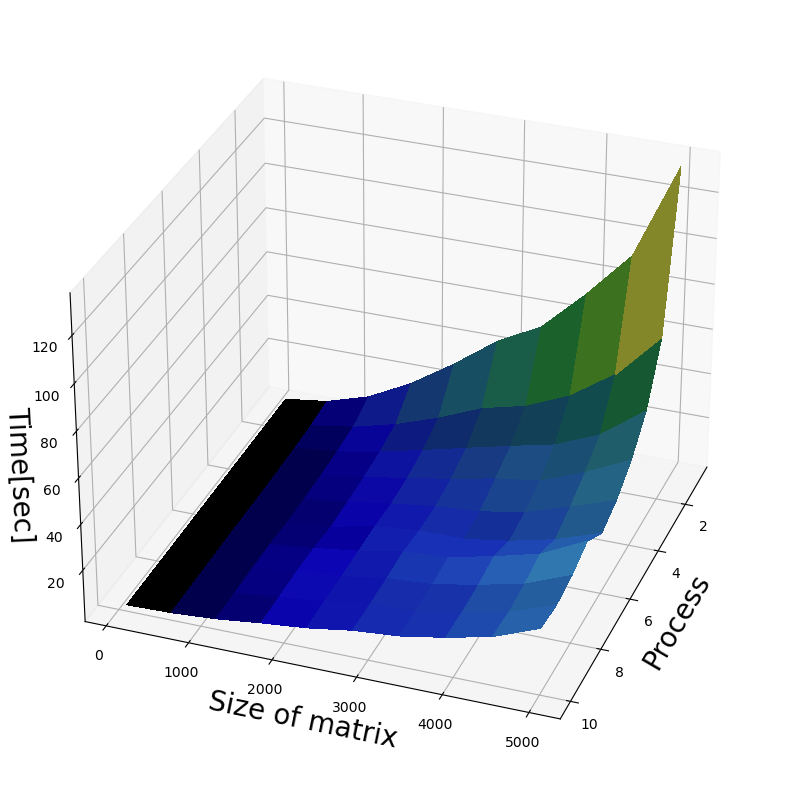

In [9]:
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))
ax.view_init(30, 20)
ax.set_xlabel("Process", fontsize = 20)
ax.set_ylabel("Size of matrix", fontsize = 20)
ax.set_zlabel("Time[sec]", fontsize = 20)

ls = LightSource(270, 45)
rgb = ls.shade(times, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(size, threads, times, rstride=1, cstride=1, facecolors=rgb,
                       linewidth=0, antialiased=False, shade=False)

plt.show()

In [29]:
import plotly.graph_objects as go

In [32]:
fig = go.Figure(data=[go.Surface(z=times, x=size, y=threads)])
fig.update_layout(title='Time consuming', autosize=False,
                  width=750, height=750,
                  margin=dict(l=65, r=50, b=65, t=90),
                  scene= go.Scene(
                    xaxis=go.XAxis(title='Process'),
                    yaxis=go.YAxis(title='size of matrix'),
                    zaxis=go.ZAxis(title='Time[sec]')))
fig.show()